## Früher vs heute: Globale Flüchtlingszahlen im Vegleich

Dieses Notebook führt eine umfangreiche statistische Analyse der globalen Flüchtlingszahlen durch.

Datensatz: `Origin_coutry_refugee_flow.csv`


## 1. Setup & Imports

In [1]:
import sys
print(sys.executable)

c:\Users\paulk\My_Drive\Statistik_project_github\.venv\Scripts\python.exe


In [2]:
import sys, subprocess

print("Aktueller Python:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "pymannkendall"])

Aktueller Python: c:\Users\paulk\My_Drive\Statistik_project_github\.venv\Scripts\python.exe


0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import mannwhitneyu, shapiro, kendalltau
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20)

## 2. Daten laden

In [4]:
df = pd.read_csv("../../output_csv_files/Origin_country_refugee_flow.csv")
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(int)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
print('Erste Zeilen:')
df.head()

Erste Zeilen:


,Origin,Year,Value
0,Afghanistan,1979,500000.0
1,Afghanistan,1980,1734921.0
2,Afghanistan,1981,3879984.0
3,Afghanistan,1982,4488214.0
4,Afghanistan,1983,4712735.0


## 3. Länderabdeckung pro Jahr bestimmen

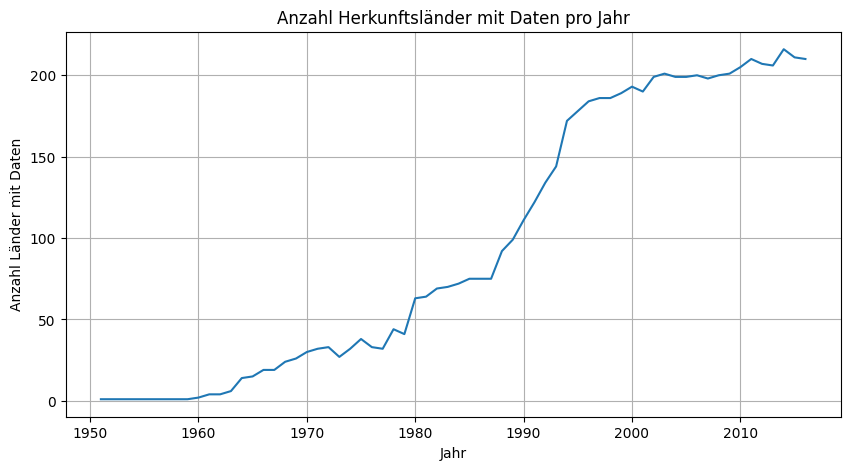

Year
2002    199
2003    201
2004    199
2005    199
2006    200
2007    198
2008    200
2009    201
2010    205
2011    210
2012    207
2013    206
2014    216
2015    211
2016    210
Name: Origin, dtype: int64

In [5]:
country_counts = df.groupby('Year')['Origin'].nunique()
plt.figure(figsize=(10, 5))
plt.plot(country_counts.index, country_counts.values)
plt.title('Anzahl Herkunftsländer mit Daten pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl Länder mit Daten')
plt.grid(True)
plt.show()
country_counts.tail(15)

## 4. Konsistente Jahre definieren (≥ 90% der maximalen Länderabdeckung)

In [6]:
threshold = 0.9 * country_counts.max()
consistent_years = country_counts[country_counts >= threshold].index
print('Max. Länderabdeckung:', country_counts.max())
print('Threshold (90% davon):', threshold)
print('Anzahl konsistente Jahre:', len(consistent_years))
print('Erste/letzte konsistente Jahre:', consistent_years.min(), '–', consistent_years.max())

Max. Länderabdeckung: 216
Threshold (90% davon): 194.4
Anzahl konsistente Jahre: 15
Erste/letzte konsistente Jahre: 2002 – 2016


## 5. Globale Flüchtlingszahlen (konsistente Jahre)

In [7]:
global_ts = df.groupby('Year')['Value'].sum()
clean_ts = global_ts[global_ts.index.isin(consistent_years)].sort_index()
print('Erste Zeilen (clean_ts):')
clean_ts.head()

Erste Zeilen (clean_ts):


Year
2002    11687879.0
2003    10589283.0
2004    10458646.0
2005     9464168.0
2006    10618994.0
Name: Value, dtype: float64

Letzte Zeilen (clean_ts):


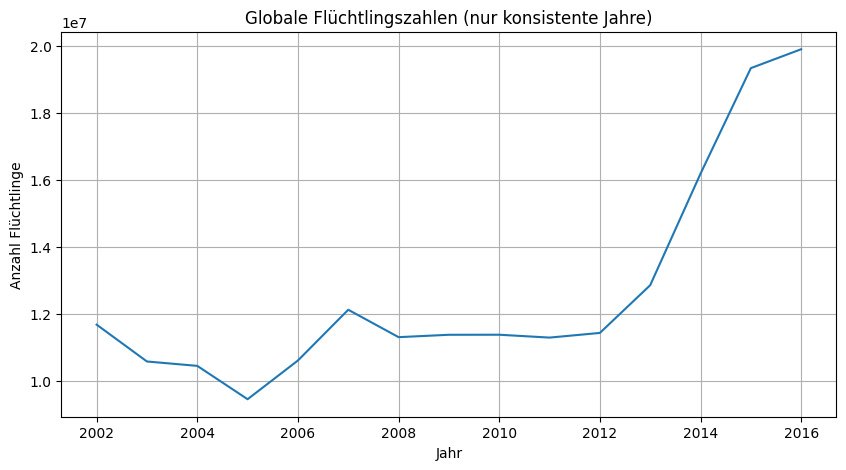

In [8]:
print('Letzte Zeilen (clean_ts):')
clean_ts.tail()

plt.figure(figsize=(10, 5))
plt.plot(clean_ts.index, clean_ts.values)
plt.title('Globale Flüchtlingszahlen (nur konsistente Jahre)')
plt.xlabel('Jahr')
plt.ylabel('Anzahl Flüchtlinge')
plt.grid(True)
plt.show()

## 6. Früher vs. Heute (innerhalb konsistenter Jahre)

In [9]:
mid_year = int(np.median(consistent_years))
print('Medianjahr der konsistenten Periode:', mid_year)
early = clean_ts[clean_ts.index < mid_year]
late = clean_ts[clean_ts.index >= mid_year]
print('Anzahl Jahre - early:', len(early), 'late:', len(late))
print('Jahre early:', early.index.min(), '–', early.index.max())
print('Jahre late:', late.index.min(), '–', late.index.max())

Medianjahr der konsistenten Periode: 2009
Anzahl Jahre - early: 7 late: 8
Jahre early: 2002 – 2008
Jahre late: 2009 – 2016


C:\Users\paulk\AppData\Local\Temp\ipykernel_35364\955298785.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([early.values, late.values], labels=[f'Früher (<{mid_year})', f'Heute (≥{mid_year})'])


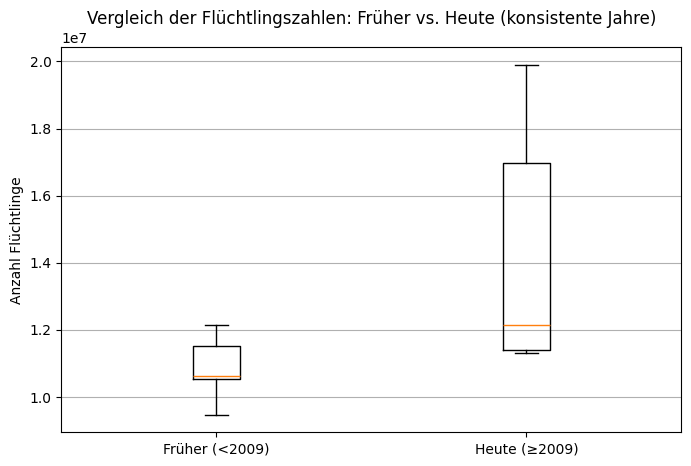

In [10]:
plt.figure(figsize=(8, 5))
plt.boxplot([early.values, late.values], labels=[f'Früher (<{mid_year})', f'Heute (≥{mid_year})'])
plt.title('Vergleich der Flüchtlingszahlen: Früher vs. Heute (konsistente Jahre)')
plt.ylabel('Anzahl Flüchtlinge')
plt.grid(True, axis='y')
plt.show()

## 7. Deskriptive Statistik

In [11]:
from scipy import stats

def describe_series(s, name):
    s = pd.Series(s).dropna()
    print(f'\n===== Deskriptive Statistik: {name} =====')
    print('Anzahl:', len(s))
    print('Mittelwert:', s.mean())
    print('Median:', s.median())
    print('Standardabweichung:', s.std())
    print('Varianz:', s.var())
    print('Minimum:', s.min())
    print('Maximum:', s.max())
    print('Schiefe (skew):', stats.skew(s))
    print('Wölbung (kurtosis):', stats.kurtosis(s))

describe_series(early, 'Früher')
describe_series(late, 'Heute')
describe_series(clean_ts, 'Gesamte Zeitreihe (konsistent)')


===== Deskriptive Statistik: Früher =====
Anzahl: 7
Mittelwert: 10895123.57142857
Median: 10618994.0
Standardabweichung: 889056.6541791842
Varianz: 790421734340.2856
Minimum: 9464168.0
Maximum: 12132040.0
Schiefe (skew): -0.15326648083108896
Wölbung (kurtosis): -0.8181566732537817

===== Deskriptive Statistik: Heute =====
Anzahl: 8
Mittelwert: 14225659.375
Median: 12152241.0
Standardabweichung: 3712088.2581144436
Varianz: 13779599236031.125
Minimum: 11301825.0
Maximum: 19900103.0
Schiefe (skew): 0.6833416165947895
Wölbung (kurtosis): -1.279896571076055

===== Deskriptive Statistik: Gesamte Zeitreihe (konsistent) =====
Anzahl: 15
Mittelwert: 12671409.333333334
Median: 11387126.0
Standardabweichung: 3191636.4851866616
Varianz: 10186543453574.666
Minimum: 9464168.0
Maximum: 19900103.0
Schiefe (skew): 1.4635403027124643
Wölbung (kurtosis): 0.7163278566965836


## 8. Normalverteilungs-Check (Shapiro-Wilk)

In [12]:
from scipy.stats import shapiro

def normality_test_shapiro(s, name):
    s = pd.Series(s).dropna()
    stat, p = shapiro(s)
    print(f'\n===== Shapiro-Wilk Normalitätstest: {name} =====')
    print('Teststatistik:', stat)
    print('p-Wert:', p)
    if p < 0.05:
        print('➡️ H0 (Normalverteilung) wird verworfen. -> Nicht normalverteilt.')
    else:
        print('➡️ H0 kann nicht verworfen werden. -> Normalverteilung plausibel.')

normality_test_shapiro(early, 'Früher')
normality_test_shapiro(late, 'Heute')


===== Shapiro-Wilk Normalitätstest: Früher =====
Teststatistik: 0.9631636609537394
p-Wert: 0.8453740844711601
➡️ H0 kann nicht verworfen werden. -> Normalverteilung plausibel.

===== Shapiro-Wilk Normalitätstest: Heute =====
Teststatistik: 0.7736685285231302
p-Wert: 0.014863498184192548
➡️ H0 (Normalverteilung) wird verworfen. -> Nicht normalverteilt.


## 9. Mann-Whitney-U-Test (Früher > Heute?)

In [13]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(early, late, alternative='greater')
print('===== Mann-Whitney-U-Test (Früher > Heute?) =====')
print('Teststatistik:', stat)
print('p-Wert:', p)
if p < 0.05:
    print('➡️ H0 wird verworfen: In den konsistenten Jahren gab es FRÜHER signifikant mehr Flüchtlinge.')
else:
    print('➡️ H0 kann nicht verworfen werden: Kein signifikanter Beleg, dass früher mehr Flüchtlinge waren.')

===== Mann-Whitney-U-Test (Früher > Heute?) =====
Teststatistik: 9.0
p-Wert: 0.9897435897435898
➡️ H0 kann nicht verworfen werden: Kein signifikanter Beleg, dass früher mehr Flüchtlinge waren.


## 10. Effektgrößen: Cohen's d und Cliff's Delta

In [14]:
import numpy as np

def cohens_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = x.mean(), y.mean()
    var_x, var_y = x.var(ddof=1), y.var(ddof=1)
    pooled_sd = np.sqrt(((nx - 1) * var_x + (ny - 1) * var_y) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_sd

def cliffs_delta(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    n_x, n_y = len(x), len(y)
    greater = 0
    less = 0
    for xi in x:
        greater += np.sum(xi > y)
        less    += np.sum(xi < y)
    delta = (greater - less) / (n_x * n_y)
    return delta

d = cohens_d(early, late)
delta = cliffs_delta(early, late)
print('===== Effektgrößen =====')
print("Cohen's d (Früher vs Heute):", d)
print("Cliff's Delta (Früher vs Heute):", delta)

def interpret_cohens_d(d):
    ad = abs(d)
    if ad < 0.2:
        return 'sehr kleiner Effekt'
    elif ad < 0.5:
        return 'kleiner bis mittlerer Effekt'
    elif ad < 0.8:
        return 'mittlerer Effekt'
    else:
        return 'großer Effekt'

def interpret_cliffs_delta(delta):
    ad = abs(delta)
    if ad < 0.147:
        return 'sehr kleiner Effekt'
    elif ad < 0.33:
        return 'kleiner Effekt'
    elif ad < 0.474:
        return 'mittlerer Effekt'
    else:
        return 'großer Effekt'

print("Interpretation Cohen's d:", interpret_cohens_d(d))
print("Interpretation Cliff's Delta:", interpret_cliffs_delta(delta))

===== Effektgrößen =====
Cohen's d (Früher vs Heute): -1.1937025361583704
Cliff's Delta (Früher vs Heute): -0.6785714285714286
Interpretation Cohen's d: großer Effekt
Interpretation Cliff's Delta: großer Effekt


## 11. Trendanalyse: Kendall's Tau & lineare Trendlinie

===== Kendall's Tau Trendtest =====
Tau: 0.6190476190476191
p-Wert: 0.0008364083878716816
➡️ Signifikanter monotone Trend (aufwärts oder abwärts).


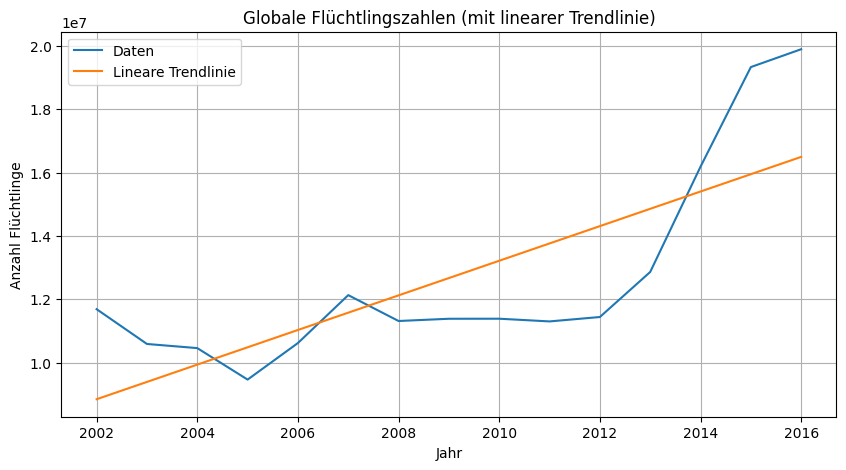

In [15]:
from scipy.stats import kendalltau

years = clean_ts.index.values
values = clean_ts.values
tau, p_tau = kendalltau(years, values)
print("===== Kendall's Tau Trendtest =====")
print('Tau:', tau)
print('p-Wert:', p_tau)
if p_tau < 0.05:
    print('➡️ Signifikanter monotone Trend (aufwärts oder abwärts).')
else:
    print('➡️ Kein signifikanter monotone Trend nachweisbar.')

coef = np.polyfit(years, values, 1)
trend_line = np.polyval(coef, years)

plt.figure(figsize=(10, 5))
plt.plot(years, values, label='Daten')
plt.plot(years, trend_line, label='Lineare Trendlinie')
plt.title('Globale Flüchtlingszahlen (mit linearer Trendlinie)')
plt.xlabel('Jahr')
plt.ylabel('Anzahl Flüchtlinge')
plt.legend()
plt.grid(True)
plt.show()

## 13. Wachstumsratenanalyse

In [16]:
growth = clean_ts.pct_change() * 100
print('Erste Wachstumsraten (%):')
growth.head(10)

Erste Wachstumsraten (%):


Year
2002          NaN
2003    -9.399447
2004    -1.233672
2005    -9.508669
2006    12.202087
2007    14.248487
2008    -6.735759
2009     0.626186
2010     0.012463
2011    -0.749100
Name: Value, dtype: float64

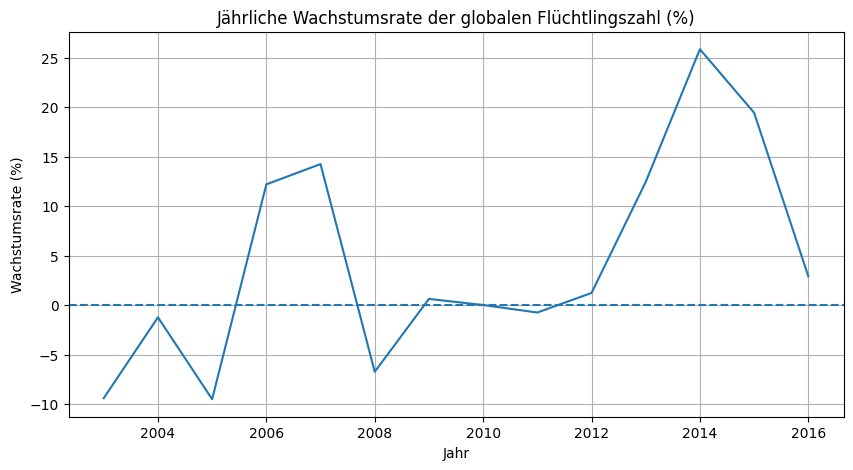


===== Deskriptive Statistik: Wachstumsrate Früher =====
Anzahl: 6
Mittelwert: -0.07116212365544576
Median: -3.9847155066862596
Standardabweichung: 10.747434212032086
Varianz: 115.50734214195776
Minimum: -9.50866871294812
Maximum: 14.248487191912895
Schiefe (skew): 0.5003603217363394
Wölbung (kurtosis): -1.5210649448487177

===== Deskriptive Statistik: Wachstumsrate Heute =====
Anzahl: 8
Mittelwert: 7.720447754102768
Median: 2.072648718921455
Standardabweichung: 10.24747256735629
Varianz: 105.01069401871972
Minimum: -0.7491003436688071
Maximum: 25.85605821267365
Schiefe (skew): 0.8331337006788047
Wölbung (kurtosis): -0.9121236255542287

===== Mann-Whitney-U-Test auf Wachstumsraten (Früher > Heute?) =====
Teststatistik: 11.0
p-Wert: 0.9593739593739594


In [17]:
plt.figure(figsize=(10, 5))
plt.plot(growth.index, growth.values)
plt.axhline(0, linestyle='--')
plt.title('Jährliche Wachstumsrate der globalen Flüchtlingszahl (%)')
plt.xlabel('Jahr')
plt.ylabel('Wachstumsrate (%)')
plt.grid(True)
plt.show()

growth_early = growth[growth.index < mid_year].dropna()
growth_late  = growth[growth.index >= mid_year].dropna()

describe_series(growth_early, 'Wachstumsrate Früher')
describe_series(growth_late,  'Wachstumsrate Heute')

stat_g, p_g = mannwhitneyu(growth_early, growth_late, alternative='greater')
print('\n===== Mann-Whitney-U-Test auf Wachstumsraten (Früher > Heute?) =====')
print('Teststatistik:', stat_g)
print('p-Wert:', p_g)

## 14. Stationaritätstest (Augmented Dickey-Fuller, ADF)

In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(clean_ts.dropna())
print('===== Augmented Dickey-Fuller Test (ADF) =====')
print('Teststatistik:', adf_result[0])
print('p-Wert:', adf_result[1])
print('Kritische Werte:')
for key, value in adf_result[4].items():
    print(f'  {key}: {value}')
if adf_result[1] < 0.05:
    print('➡️ H0 (Unit Root / Nicht-Stationarität) wird verworfen -> Zeitreihe stationär.')
else:
    print('➡️ H0 kann nicht verworfen werden -> Zeitreihe wahrscheinlich nicht stationär.')

===== Augmented Dickey-Fuller Test (ADF) =====
Teststatistik: 1.1756752794600116
p-Wert: 0.9958134373100354
Kritische Werte:
  1%: -4.01203360058309
  5%: -3.1041838775510207
  10%: -2.6909873469387753
➡️ H0 kann nicht verworfen werden -> Zeitreihe wahrscheinlich nicht stationär.
